In [175]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from imageio import imwrite, imread
from matplotlib.pyplot import figure, show, close, xlabel, ylabel, title
from scipy.constants import k, h, c,e
import sympy as sp
from scipy.optimize import curve_fit
from astropy.visualization import simple_norm, MinMaxInterval

In [176]:
vega_data = np.loadtxt("baseline_subtracted.txt", comments="#")
print(vega_data)

[7243.07636459 7254.32246281 7451.21975527 ...  871.94500451  874.95074311
  876.01626339]


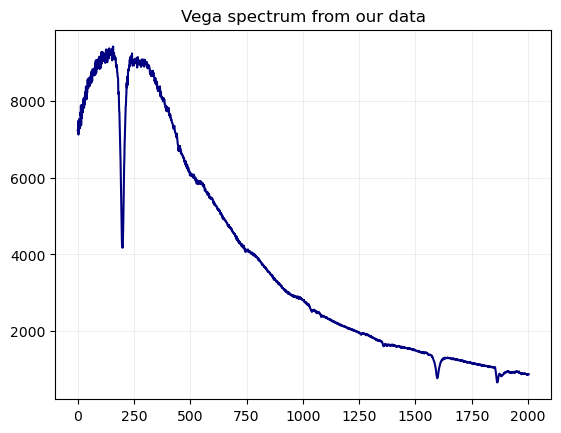

In [177]:
fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(vega_data,color="navy", label="Vega spectrum")
frame.set_title("Vega spectrum from our data")
frame.grid(alpha=0.2)
show()
close(fig)

Filename: miles spectra/vega_miles.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   

data shape: (1, 4367)


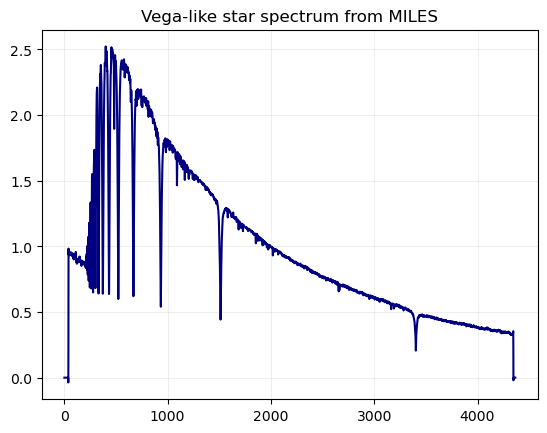

In [178]:
# getting some basic information on the miles spectrum

hdulist = fits.open('miles spectra/vega_miles.fits')
hdulist.info()
print()

hdr = hdulist[0].header
dat = hdulist[0].data
print(f"data shape: {dat.shape}")
vega_miles = dat[0,:]

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(vega_miles,color="navy", label="Vega spectrum")
frame.set_title("Vega-like star spectrum from MILES")
frame.grid(alpha=0.2)
show()
close(fig)


In [179]:
# checking coherence
print(dat.any())
print(dat.all())
print(hdr)

True
False
SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                 4367 / length of data axis 1                          NAXIS2  =                    1 / length of data axis 2                          COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H COMMENT ----------------------------------------------------------------------  COMMENT ************************** REDUCEME HEADER ***************************  COMMENT ----------------------------------------------------------------------  HISTORY Date: 06/10/**                                                          CRPIX1  =                 1.00                                                  CRVAL1  =            3500.000

In [180]:
hdulist.close()

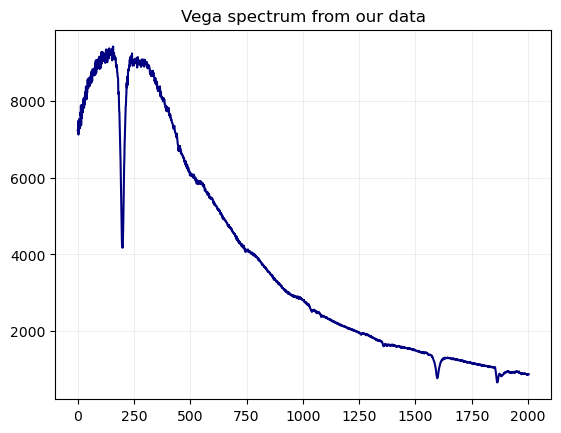

In [181]:
# defining functions for fitting the spectra

def f_gaussian(x, amp, mu, sigma, zero):
    """returns the value of a Gaussian function with amplitude amp centered at position mu with width sigma and 
    offset with respect to the x-axis off zero"""
    # amp, mu, sigma, zero = p
    return amp * np.exp(-(x - mu) * (x - mu) / (2.0 * sigma * sigma)) + zero

def f_black_body(x, T):
    """returns the value of a black body curve equation for temperature T at position x"""
    #T=p[0]
    f=(((2*h)/((c**2)*(x**3)))*(1/(e**(h/(x*k*T))-1)))
    return f

#
#b

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(vega_data,color="navy", label="Vega spectrum")
#frame.plot(f_black_body(np.arange(1,vega_data.size + 1), fitted_T),color="lightblue", label="Fitted Temperature")
frame.set_title("Vega spectrum from our data")
frame.grid(alpha=0.2)
show()
close(fig)


Filename: Reynier files/vega_wl.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2004,)   float32   

data shape: (1, 4367)


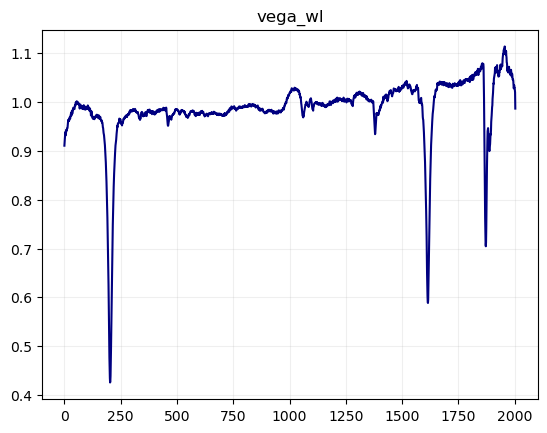

Filename: Reynier files/vega1_wl.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2003,)   float32   

data shape: (1, 4367)


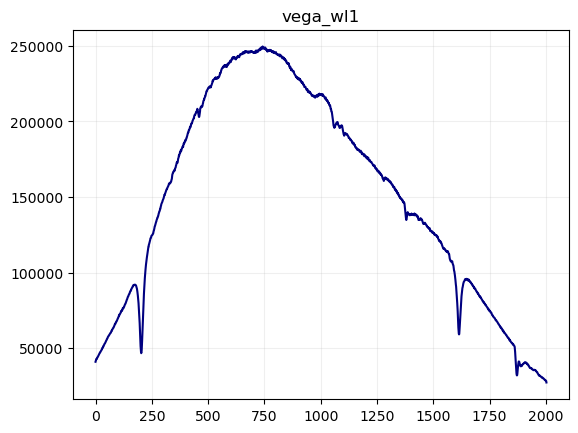

In [182]:
hdulist = fits.open('Reynier files/vega_wl.fits')
hdulist.info()
print()

hdr = hdulist[0].header
dat_vega_0 = hdulist[0].data
print(f"data shape: {dat.shape}")


fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(dat_vega_0,color="navy", label="Vega spectrum")
frame.set_title("vega_wl")
frame.grid(alpha=0.2)
show()
close(fig)

hdulist.close()
hdulist = fits.open('Reynier files/vega1_wl.fits')
hdulist.info()
print()

hdr = hdulist[0].header
dat_vega_1 = hdulist[0].data
print(f"data shape: {dat.shape}")


fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(dat_vega_1,color="navy", label="Vega spectrum")
frame.set_title("vega_wl1")
frame.grid(alpha=0.2)
show()
close(fig)
hdulist.close()

[ -0.51061994 204.30375662  10.77127229   0.993915  ]


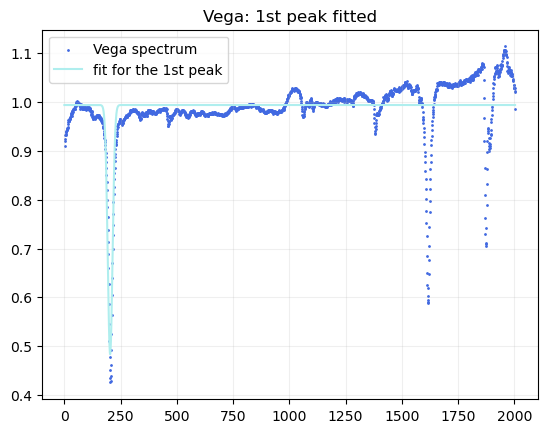

In [183]:
# Making a Gaussian fit for the 1st absorption peak, plotting it

beta, pcov1 = curve_fit(f_gaussian, np.arange(1, dat_vega_0.size+1), dat_vega_0, p0=(-0.6, 190, 40, 1))
#amp, mu, sigma, zero

print(beta)

a1,m1,s1,z1=beta
x_range = np.arange(1, dat_vega_0.size+1)

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range,dat_vega_0,color="royalblue", label="Vega spectrum",s=1)
frame.plot(f_gaussian(x_range,a1,m1,s1,z1),color="paleturquoise", label="fit for the 1st peak")
frame.set_title("Vega: 1st peak fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

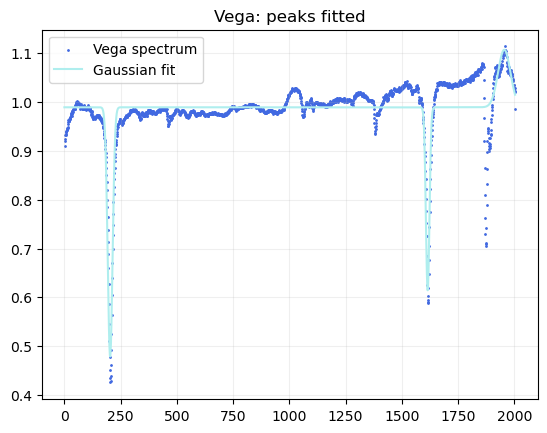

In [184]:
# I will take the offset fit for all three peak fits and take the mean, to obtain the average value
# or the weighted average, i'll see which one yields more accurate data

# also the fit doesn't really reach the bottom of the peak??? i don't know why, i'll TODO: try to find a better way to fit it if i have the time
# shouldn't really matter for the FWHM anyway

beta, pcov2 = curve_fit(f_gaussian, x_range, dat_vega_0, p0=(-0.4, 1600, 20, 1.02))
#amp, mu, sigma, zero
# print(beta)
a2,m2,s2,z2=beta

beta, pcov3 = curve_fit(f_gaussian, x_range, dat_vega_0, p0=(-0.4, 1950, 20, 1.05))
a3,m3,s3,z3=beta

z = np.mean([z1,z2,z3])


f_composed = f_gaussian(x_range,a1,m1,s1,z)+f_gaussian(x_range,a2,m2,s2,0)+f_gaussian(x_range,a3,m3,s3,0)
fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range,dat_vega_0,color="royalblue", label="Vega spectrum",s=1)
frame.plot(f_composed,color="paleturquoise", label="Gaussian fit")
frame.set_title("Vega: peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

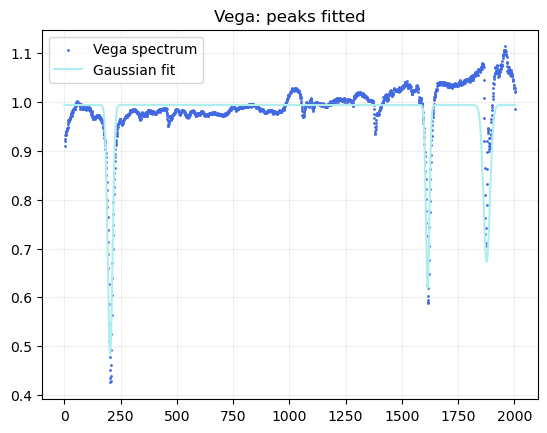

In [185]:
# separate code for the 3rd peak because it's being quirky; TODO: add 4th peak at ~1400 
# wait is it an emission peak??? should vega even have emission?????? no it shouldn't
# my interpretation: H-alpha (~6600 A), H-beta (~4850 A), O2 band (~6950) TODO: make it an actual band

x_range_3rdpeak = np.arange(1850,1900)

beta, pcov3 = curve_fit(f_gaussian, x_range_3rdpeak, dat_vega_0[1850:1900], p0=(-0.4, 1900, 20, 1.05))

a3,m3,s3,z3=beta
# f_3rdpeak = np.zeros(x_range)
# f_3rdpeak[range(1850,1900)]=f_gaussian(x_range,a3,m3,s3,0)

z = np.median([z1,z2,z3])

f_composed = f_gaussian(x_range,a1,m1,s1,z)+f_gaussian(x_range,a2,m2,s2,0)+f_gaussian(x_range,a3,m3,s3,0)
fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range,dat_vega_0,color="royalblue", label="Vega spectrum",s=1)
frame.plot(f_composed,color="paleturquoise", label="Gaussian fit")
frame.set_title("Vega: peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

In [186]:
def fwhm_calculator(sigma,pcov):
    """Calculates the equivalent width from a given sigma value and its error using the pcov matrix"""
    fwhm=2*sigma*np.sqrt(2*np.log(2))
    err=np.sqrt(np.diag(pcov))
    fwhm_err=2*err[2]*np.sqrt(2*np.log(2))
    return fwhm,fwhm_err

fwhm1,fwhm1_err=fwhm_calculator(s1,pcov1)
fwhm2,fwhm2_err=fwhm_calculator(s2,pcov2)
fwhm3,fwhm3_err=fwhm_calculator(s3,pcov3)

print(f"H-alpha peak width: {fwhm1}, error: {fwhm1_err}")
print(f"H-beta peak width: {fwhm2}, error: {fwhm2_err}")
print(f"O2 band width: {fwhm3}, error: {fwhm3_err}")

H-alpha peak width: 25.364407887995966, error: 0.767719837133825
H-beta peak width: 18.64498476912358, error: 1.1485840316682896
O2 band width: 34.12452985096749, error: 10.434713925349884


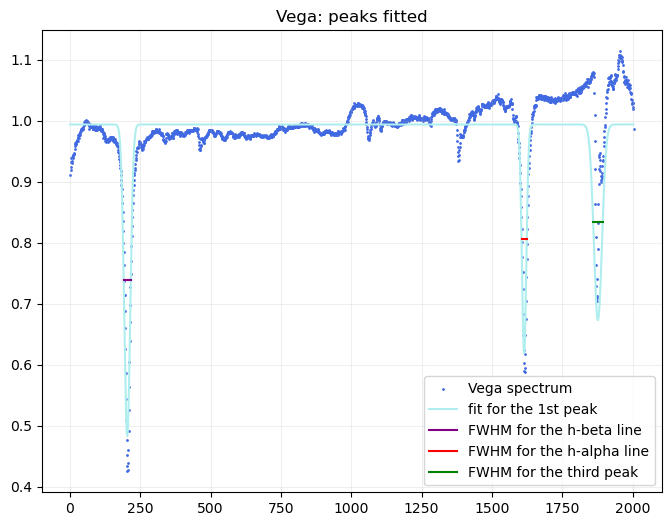

In [187]:
# plotting the FWHMs

fwhm1_x=np.array((m1-fwhm1/2,m1+fwhm1/2))
fwhm1_y=np.array((a1/2+z,a1/2+z))

fwhm2_x=np.array((m2-fwhm2/2,m2+fwhm2/2))
fwhm2_y=np.array((a2/2+z,a2/2+z))

fwhm3_x=np.array((m3-fwhm3/2,m3+fwhm3/2))
fwhm3_y=np.array((a3/2+z,a3/2+z))

fig=figure(figsize=(8,6))
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range,dat_vega_0,color="royalblue", label="Vega spectrum",s=1)
frame.plot(f_composed,color="paleturquoise", label="fit for the 1st peak")
frame.plot(fwhm1_x,fwhm1_y,color="purple", label="FWHM for the h-beta line")
frame.plot(fwhm2_x,fwhm2_y,color="red", label="FWHM for the h-alpha line")
frame.plot(fwhm3_x,fwhm3_y,color="green", label="FWHM for the third peak")
frame.set_title("Vega: peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

H-alpha peak width: 30.580396062309653 Angstroms, error: 0.9255952982665566
H-beta peak width: 22.47917717351372 Angstroms, error: 1.3847811766141669
O2 band width: 41.1419672357723 Angstroms, error: 12.580529616270459


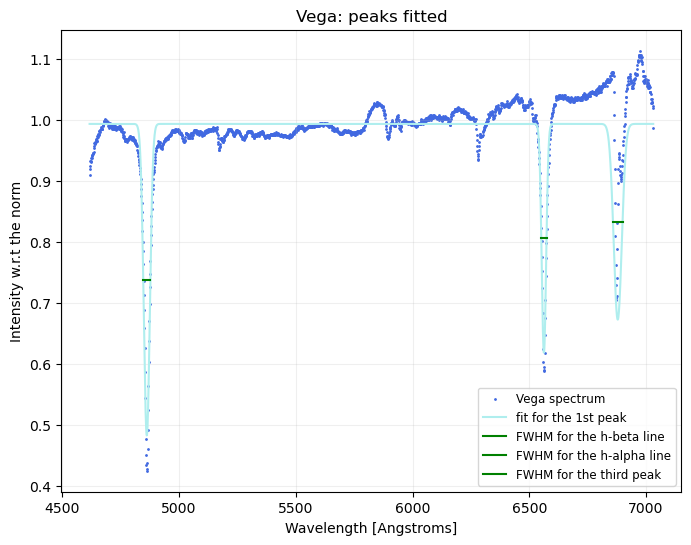

In [188]:
# TODO: actually add docstrings to all methods/functions


# a function to convert values from pixels to Angstroms 
def pix_to_A_parameters (p1,p2,a1,a2):
    """Takes two point values as arguments, each consisting of a position of a peak in pixels and the corresponding wavelength in Angstroms, where p1<p2 and a1<a2.
    Assumes that the spectroscope is, like, good"""
    scale=((a2-a1)/(p2-p1))
    offset = scale*-p1+a1
    return scale,offset

    
# m1 -> beta
# m2 -> alpha
    
h_beta = 4861.35
h_alpha = 6562.79 #source: wikipedia + unit converter from nm, sorry :((

a_in_pix, a_off = pix_to_A_parameters(m1,m2,h_beta,h_alpha)

# 
def pix_to_A (a):
    """Function to simplify the conversion of values/numpy array from values in pixels to Angstroms"""
    return a*a_in_pix+a_off

# x_range_a=x_range*a_in_pix+a_off
x_range_a = pix_to_A(x_range)

print(f"H-alpha peak width: {a_in_pix*fwhm1} Angstroms, error: {a_in_pix*fwhm1_err}")
print(f"H-beta peak width: {a_in_pix*fwhm2} Angstroms, error: {a_in_pix*fwhm2_err}")
print(f"O2 band width: {a_in_pix*fwhm3} Angstroms, error: {a_in_pix*fwhm3_err}")

fig=figure(figsize=(8,6))
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range_a,dat_vega_0,color="royalblue", label="Vega spectrum",s=1)
frame.plot(x_range_a,f_composed,color="paleturquoise", label="fit for the 1st peak")
frame.plot(fwhm1_x*a_in_pix+a_off,fwhm1_y,color="green", label="FWHM for the h-beta line")
frame.plot(fwhm2_x*a_in_pix+a_off,fwhm2_y,color="green", label="FWHM for the h-alpha line")
frame.plot(fwhm3_x*a_in_pix+a_off,fwhm3_y,color="green", label="FWHM for the third peak")
frame.set_title("Vega: peaks fitted")
frame.grid(alpha=0.2)
frame.set_ylabel("Intensity w.r.t the norm")
frame.set_xlabel("Wavelength [Angstroms]")
frame.legend(fontsize=8.5)
show()
close(fig)

# C R I S P


        

[1.7904861  1.8005823  1.80714    ... 0.38567284 0.3792054  0.37885448]


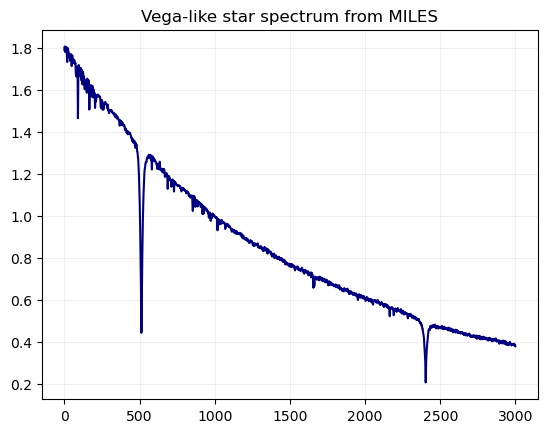

[1.7904861  1.8005823  1.80714    ... 0.38567284 0.3792054  0.37885448]


In [189]:
# the fight with MILES continues

print(vega_miles[1000:4000])

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(vega_miles[1000:4000],color="navy", label="Vega spectrum") # the section of the data that seems relevant
frame.set_title("Vega-like star spectrum from MILES")
frame.grid(alpha=0.2)
show()
close(fig)

print(vega_miles[1000:4000])

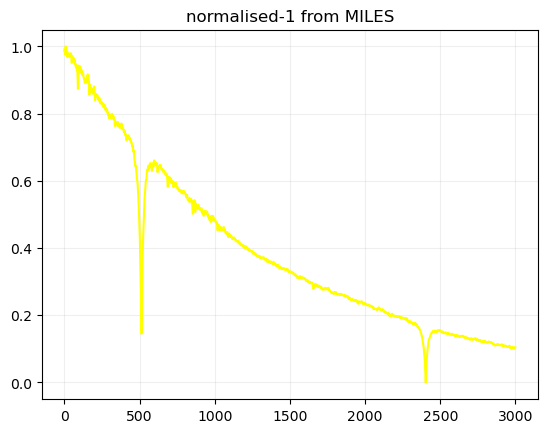

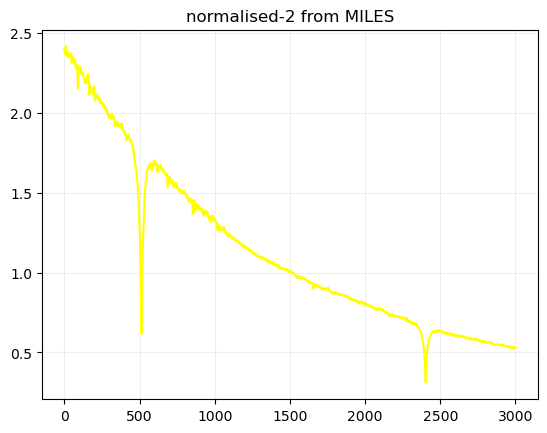

In [193]:
# first ~400 still looks like ventricular fibrillation (aka heart attack) but gonna normalise it and see where it leads
# defining the normalization function using the normal statistics formula
def normalize_spectrum(wavelengths, intensities):
    min_intensity = np.min(intensities)
    max_intensity = np.max(intensities)
    normalized_intensities = (intensities - min_intensity) / (max_intensity - min_intensity)
    return normalized_intensities

#defining the normalization function using some quirky thing from PROGNUM material
def normalize_quirky(wavelengths, intensities):
    normalised_spectrum = intensities/np.median(intensities)
    return normalised_spectrum
    

x_range_miles=np.arange(1000, 4000)

normalized_vega_miles = normalize_spectrum(x_range_miles, vega_miles[1000:4000])

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(normalized_vega_miles,color="yellow", label="Vega spectrum") # the section of the data that seems relevant
frame.set_title("normalised-1 from MILES")
frame.grid(alpha=0.2)
show()
close(fig)

normalized_vega_miles2 = normalize_quirky(x_range_miles, vega_miles[1000:4000])

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(normalized_vega_miles2,color="yellow", label="Vega spectrum")
frame.set_title("normalised-2 from MILES")
frame.grid(alpha=0.2)
show()
close(fig)


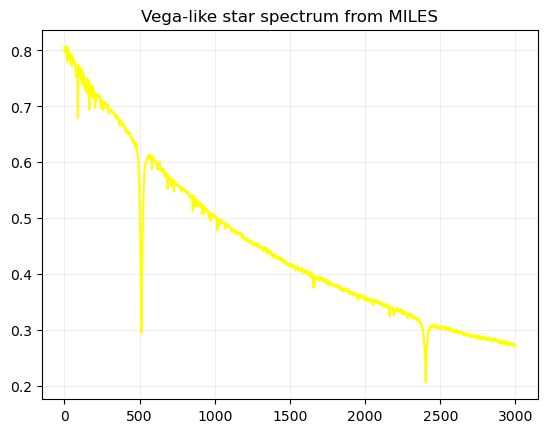

In [191]:
# print(vega_miles[1000:4000].shape)
# print(vega_data[1000:4000].shape)
# print(normalized_vega_miles2.shape)
# vega_miles_no_baseline=vega_miles[1000:4000]-normalized_vega_miles
# 
# fig=figure()
# frame=fig.add_subplot(1,1,1)
# frame.plot(vega_miles_no_baseline,color="yellow", label="Vega spectrum") # the section of the data that seems relevant
# frame.set_title("Vega-like star spectrum from MILES")
# frame.grid(alpha=0.2)
# show()
# close(fig)


In [194]:
# fitting black body curve to our Vega

T = 9600

vega_curve=curve_fit(f_black_body,x_range_miles,vega_miles[1000:4000],p0=T)

#fitted_T = beta[0]
#print(f"Fitted Temperature: {fitted_T}")

C:\Users\bukow\AppData\Local\Temp\ipykernel_31628\1841647974.py:12: RuntimeWarning: divide by zero encountered in divide
  f=(((2*h)/((c**2)*(x**3)))*(1/(e**(h/(x*k*T))-1)))


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 400.

Filename: miles spectra/vega2_miles.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   

data shape: (1, 4367)


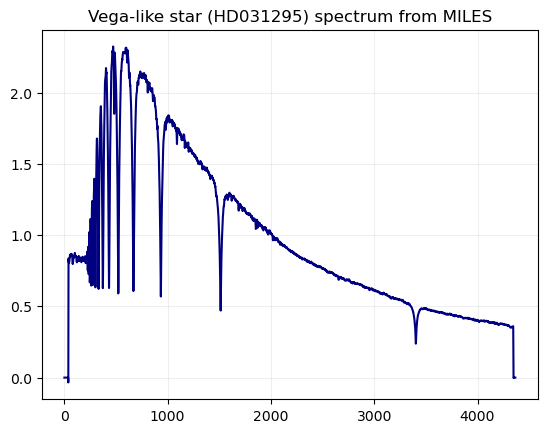

In [192]:
# trying to figure out if it's the spectrum that doesn't make sense of if i'm just dumb

# getting some basic information on the miles spectrum

hdulist = fits.open('miles spectra/vega2_miles.fits')
hdulist.info()
print()

hdr = hdulist[0].header
dat = hdulist[0].data
print(f"data shape: {dat.shape}")
vega_miles = dat[0,:]

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(vega_miles,color="navy", label="Vega spectrum")
frame.set_title("Vega-like star (HD031295) spectrum from MILES")
frame.grid(alpha=0.2)
show()
close(fig)

#i'm officially stupid
# i figured it out, but i'll let it stay for future use? (maybe?)
# ACTUALLy
# TODO: also get equivalent width for the 2nd Vega-like star and ??? take mean or sth

here's the GitHub commit message prefixes:
-feat (add feature)
-fix (repaired bug/broken code)
-refactor (changed code structure but didnt add new features)
-style (if you just changed some minor thing, spelling, variable names, ect.)